In [1]:
# ==========================================
# Imports: Data handling, visualisation, ML
# ==========================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Model training & evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Classifiers
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
# Hyperparameter search distributions
from scipy.stats import randint

# Reproducibility
RANDOM_STATE = 42


In [2]:
# ============================
# Load dataset and basic checks
# ============================

df_intrusion = pd.read_csv("cybersecurity_intrusion_data.csv")

rows, cols = df_intrusion.shape
print(f"Dataset successfully loaded.")
print(f"Rows: {rows}")
print(f"Columns: {cols}\n")

print("Preview of the dataset:")
display(df_intrusion.head())

print("\nDataset information:")
df_intrusion.info()


Dataset successfully loaded.
Rows: 9537
Columns: 11

Preview of the dataset:


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [3]:
# ======================
# Missing value handling
# ======================

print("Missing values per column:\n")
display(df_intrusion.isnull().sum())

print(f"\nDoes the dataset contain any missing values? -> {df_intrusion.isnull().any().any()}\n")

# Create the cleaned dataset (this defines df_intrusion_clean)
df_intrusion_clean = df_intrusion.dropna()

rows_clean, cols_clean = df_intrusion_clean.shape
print("Dataset after removing missing values:")
print(f"Rows: {rows_clean}")
print(f"Columns: {cols_clean}\n")

print("Preview of cleaned dataset:")
display(df_intrusion_clean.head())


Missing values per column:



session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


Does the dataset contain any missing values? -> True

Dataset after removing missing values:
Rows: 7571
Columns: 11

Preview of cleaned dataset:


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [4]:
# ===================================
# Drop ID-only / non-predictive columns
# ===================================

# session_id: identifier only, not useful for prediction
# Note: We keep 'encryption_used' because we will test models with networking features included
cols_to_drop = ['session_id']

df_intrusion_clean = df_intrusion_clean.drop(columns=cols_to_drop)

print("Columns dropped:", cols_to_drop)
print("Shape after dropping non-predictive columns:", df_intrusion_clean.shape)


# =========================
# Descriptive statistics
# =========================

print("\nDescriptive statistics for numeric features:\n")
display(df_intrusion_clean.describe().T)


Columns dropped: ['session_id']
Shape after dropping non-predictive columns: (7571, 10)

Descriptive statistics for numeric features:



,count,mean,std,min,25%,50%,75%,max
network_packet_size,7571.0,499.556598,198.458221,64.000000,364.000000,498.000000,632.000000,1285.000000
login_attempts,7571.0,4.031832,1.963112,1.000000,3.000000,4.000000,5.000000,13.000000
session_duration,7571.0,789.334671,789.993725,0.500000,230.590993,547.137302,1101.216078,7190.392213
ip_reputation_score,7571.0,0.330749,0.177953,0.002497,0.190350,0.313306,0.453525,0.924299
failed_logins,7571.0,1.523313,1.036751,0.000000,1.000000,1.000000,2.000000,5.000000
unusual_time_access,7571.0,0.150707,0.357786,0.000000,0.000000,0.000000,0.000000,1.000000
attack_detected,7571.0,0.443006,0.496774,0.000000,0.000000,0.000000,1.000000,1.000000


In [5]:
df_intrusion.isnull().sum()

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

In [6]:
df_intrusion.duplicated().sum()

np.int64(0)

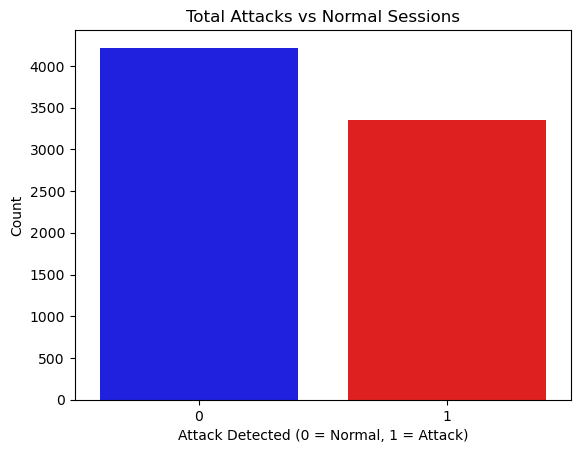

C:\Users\munif\AppData\Local\Temp\ipykernel_23284\2536506943.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


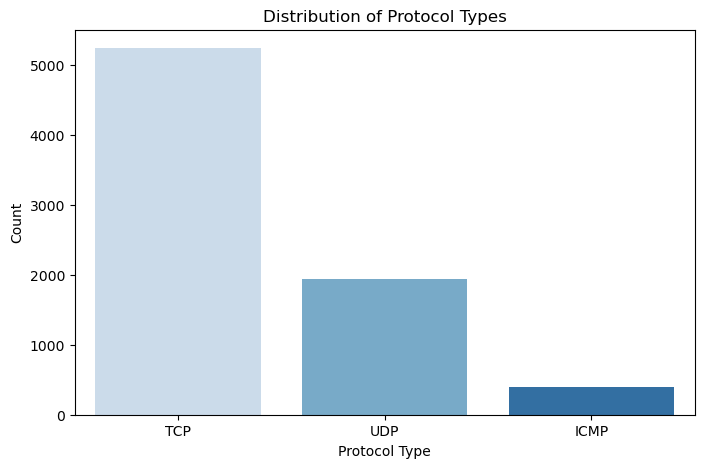

C:\Users\munif\AppData\Local\Temp\ipykernel_23284\2536506943.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


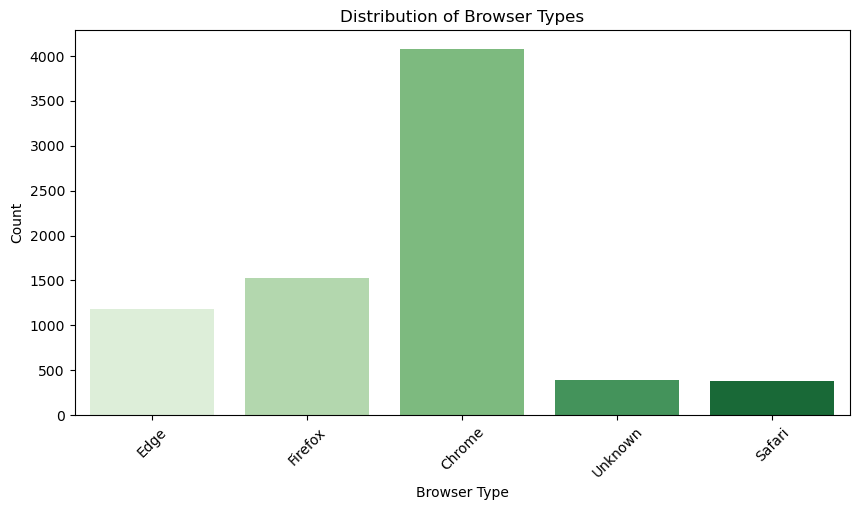

C:\Users\munif\AppData\Local\Temp\ipykernel_23284\2536506943.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


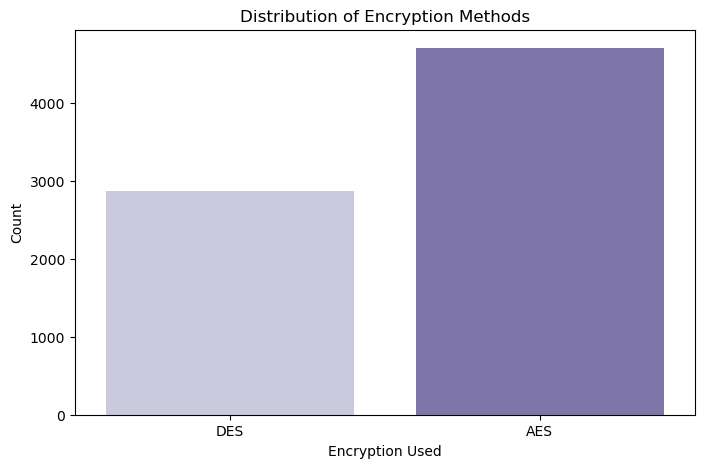

In [7]:
# =======================
# Class distribution plot
# =======================

sns.countplot(
    x="attack_detected",
    data=df_intrusion_clean,
    hue="attack_detected",
    palette={0: "blue", 1: "red"},
    legend=False
)

plt.title("Total Attacks vs Normal Sessions")
plt.xlabel("Attack Detected (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

# ================================
# Protocol Type Distribution
# ================================
plt.figure(figsize=(8, 5))
sns.countplot(
    x="protocol_type",
    data=df_intrusion_clean,
    palette="Blues"
)
plt.title("Distribution of Protocol Types")
plt.xlabel("Protocol Type")
plt.ylabel("Count")
plt.show()

# ================================
# Browser Type Distribution
# ================================
plt.figure(figsize=(10, 5))
sns.countplot(
    x="browser_type",
    data=df_intrusion_clean,
    palette="Greens"
)
plt.title("Distribution of Browser Types")
plt.xlabel("Browser Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ================================
# Encryption Method Distribution
# ================================
plt.figure(figsize=(8, 5))
sns.countplot(
    x="encryption_used",
    data=df_intrusion_clean,
    palette="Purples"
)
plt.title("Distribution of Encryption Methods")
plt.xlabel("Encryption Used")
plt.ylabel("Count")
plt.show()


In [8]:
# ==========================
# Encode categorical features
# ==========================

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Encode categorical columns in the CLEAN dataset
categorical_cols = ["protocol_type", "browser_type", "encryption_used"]

for col in categorical_cols:
    df_intrusion_clean[col] = le.fit_transform(df_intrusion_clean[col])

print("Categorical columns encoded:", categorical_cols)
display(df_intrusion_clean.head())


Categorical columns encoded: ['protocol_type', 'browser_type', 'encryption_used']


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,599,1,4,492.983263,1,0.606818,1,1,0,1
1,472,1,3,1557.996461,1,0.301569,0,2,0,0
2,629,1,3,75.044262,1,0.739164,2,0,0,1
3,804,2,4,601.248835,1,0.123267,0,4,0,1
4,453,1,5,532.540888,0,0.054874,1,2,0,0


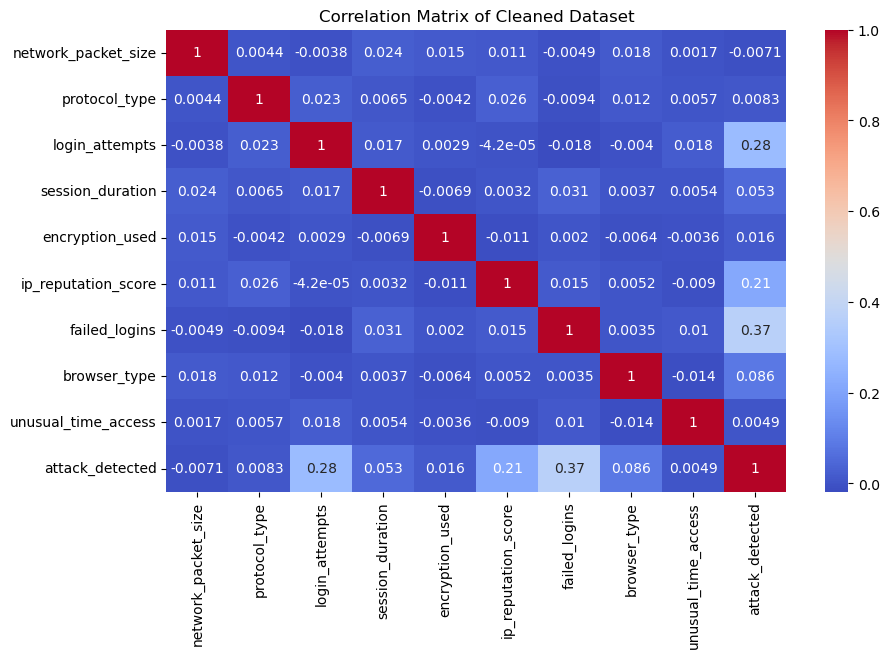

In [9]:
# ==========================
# Correlation heatmap
# ==========================

plt.figure(figsize=(10,6))
sns.heatmap(df_intrusion_clean.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Cleaned Dataset")
plt.show()


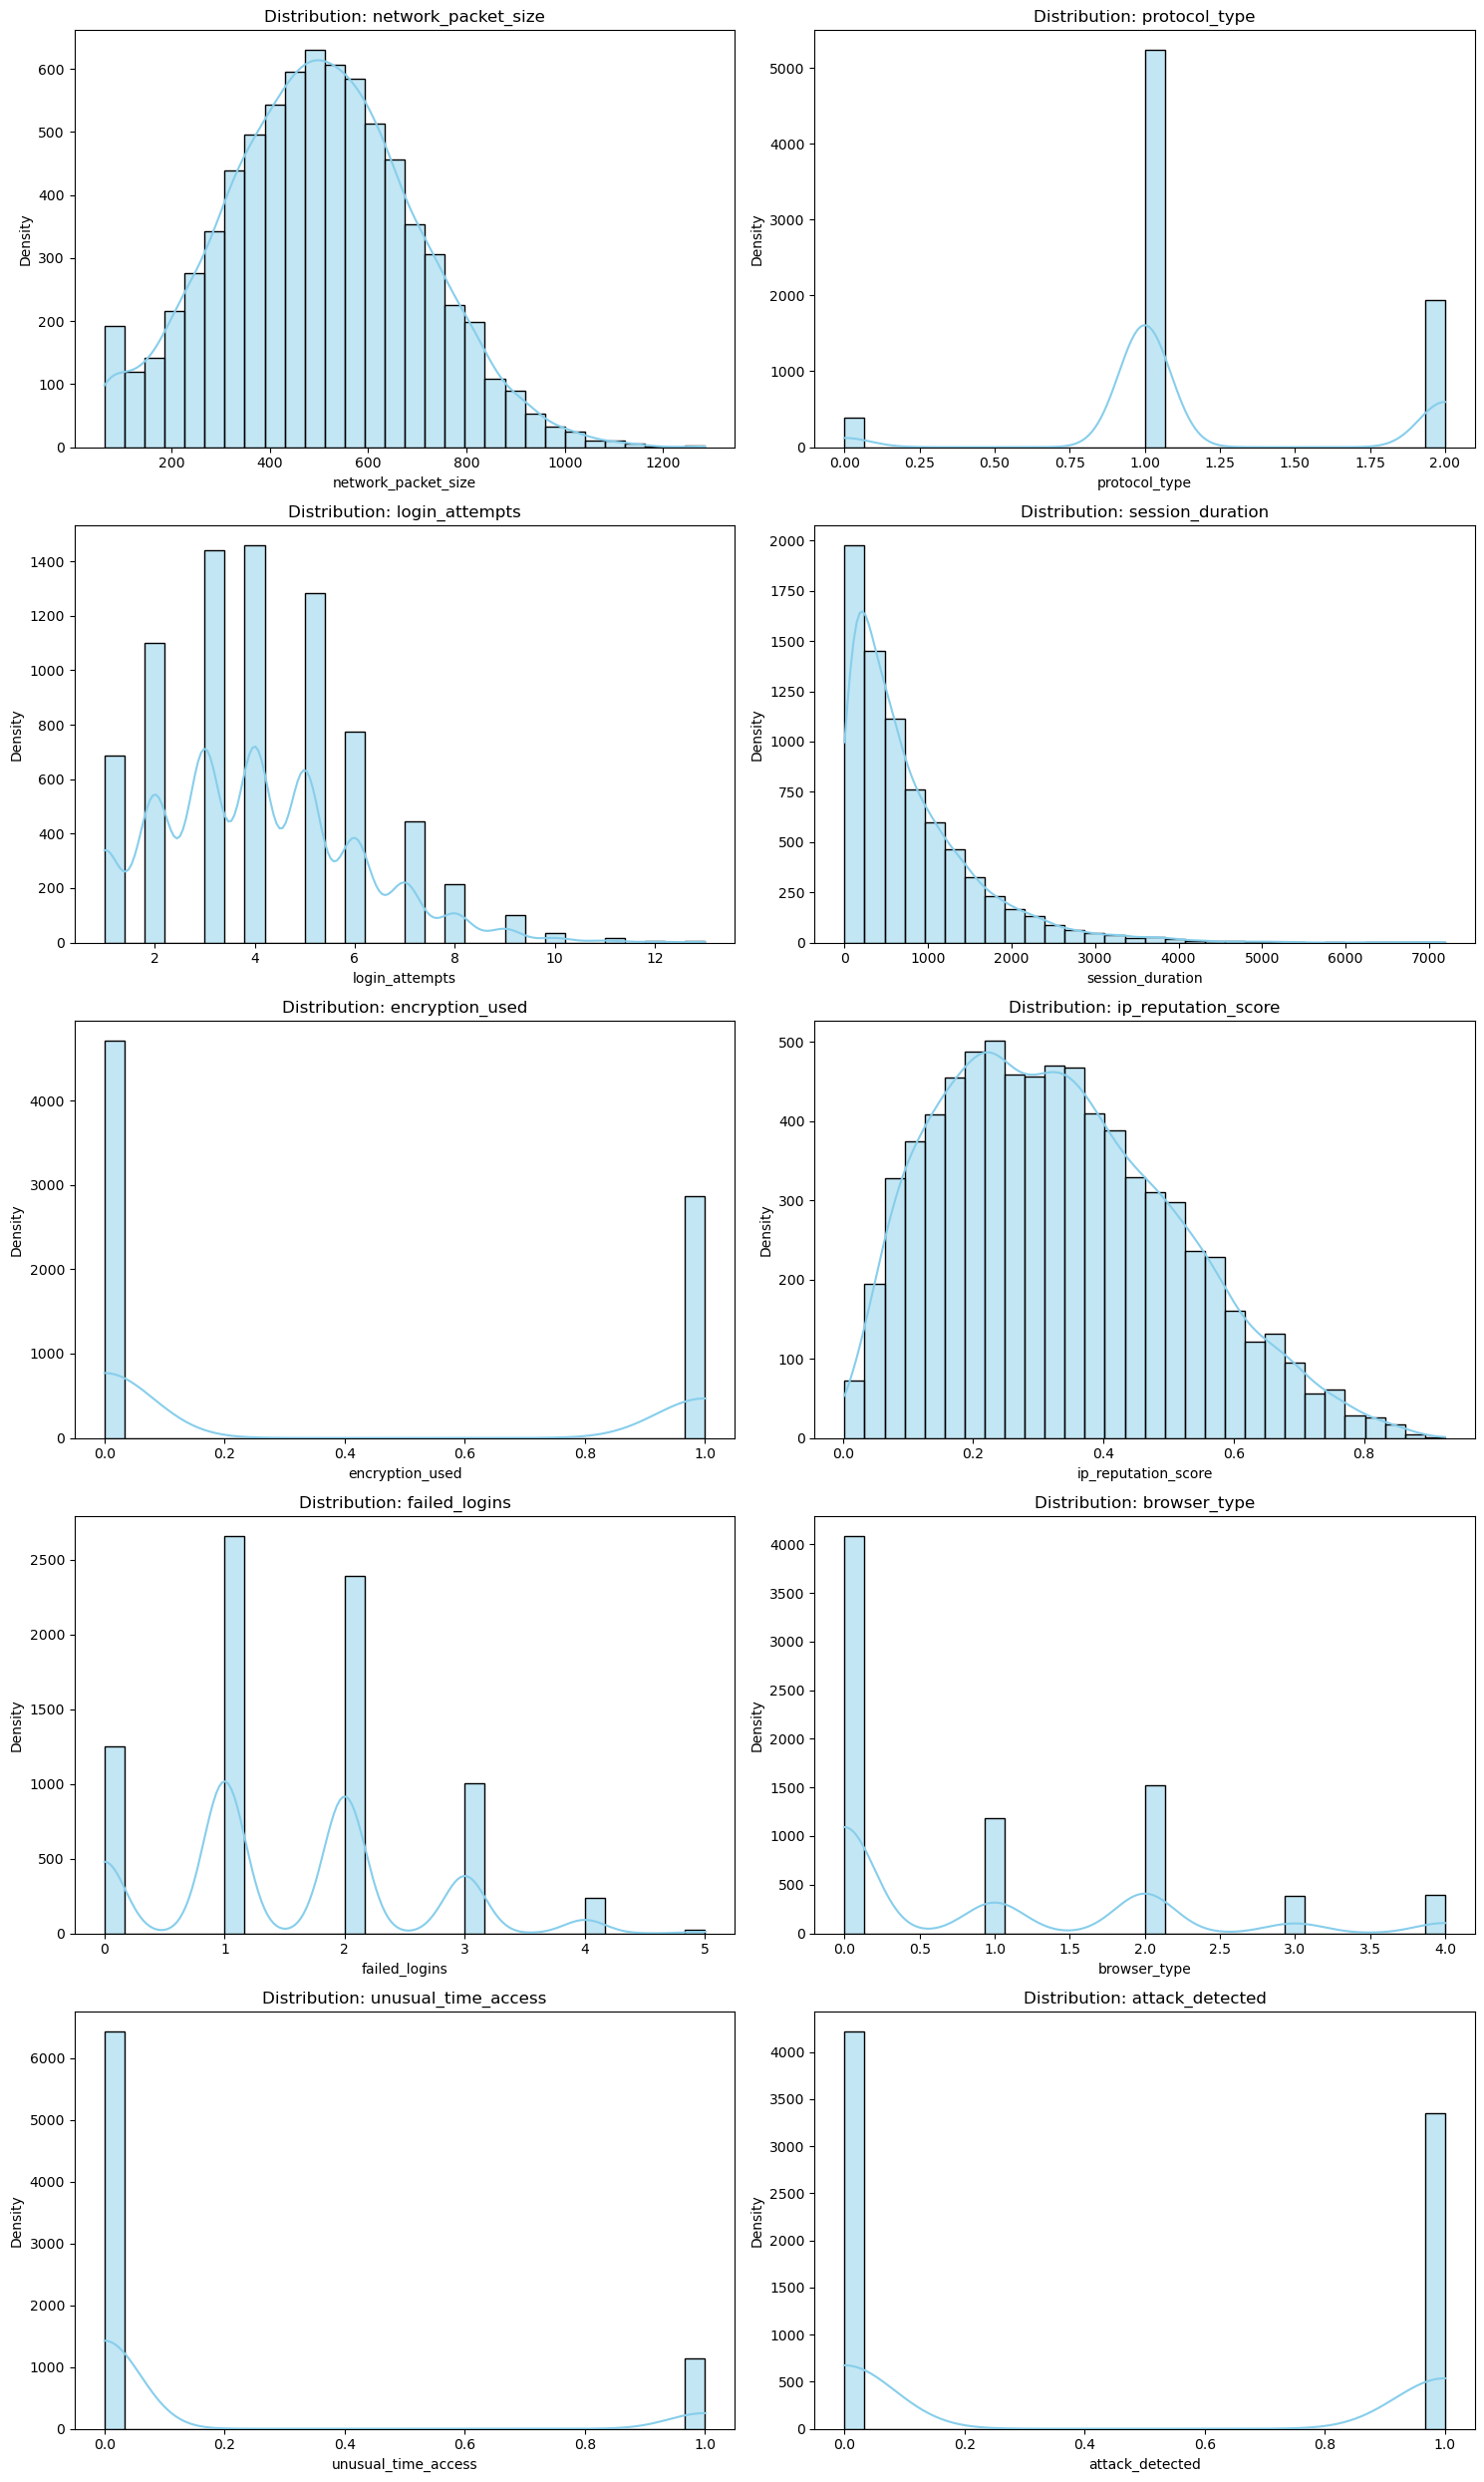

In [10]:
# ==========================
# Distribution Plots
# ==========================

numeric_cols = df_intrusion_clean.select_dtypes(include=[np.number]).columns
num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df_intrusion_clean[column], kde=True, color='skyblue', bins=30)
    plt.title(f"Distribution: {column}")
    plt.xlabel(column)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


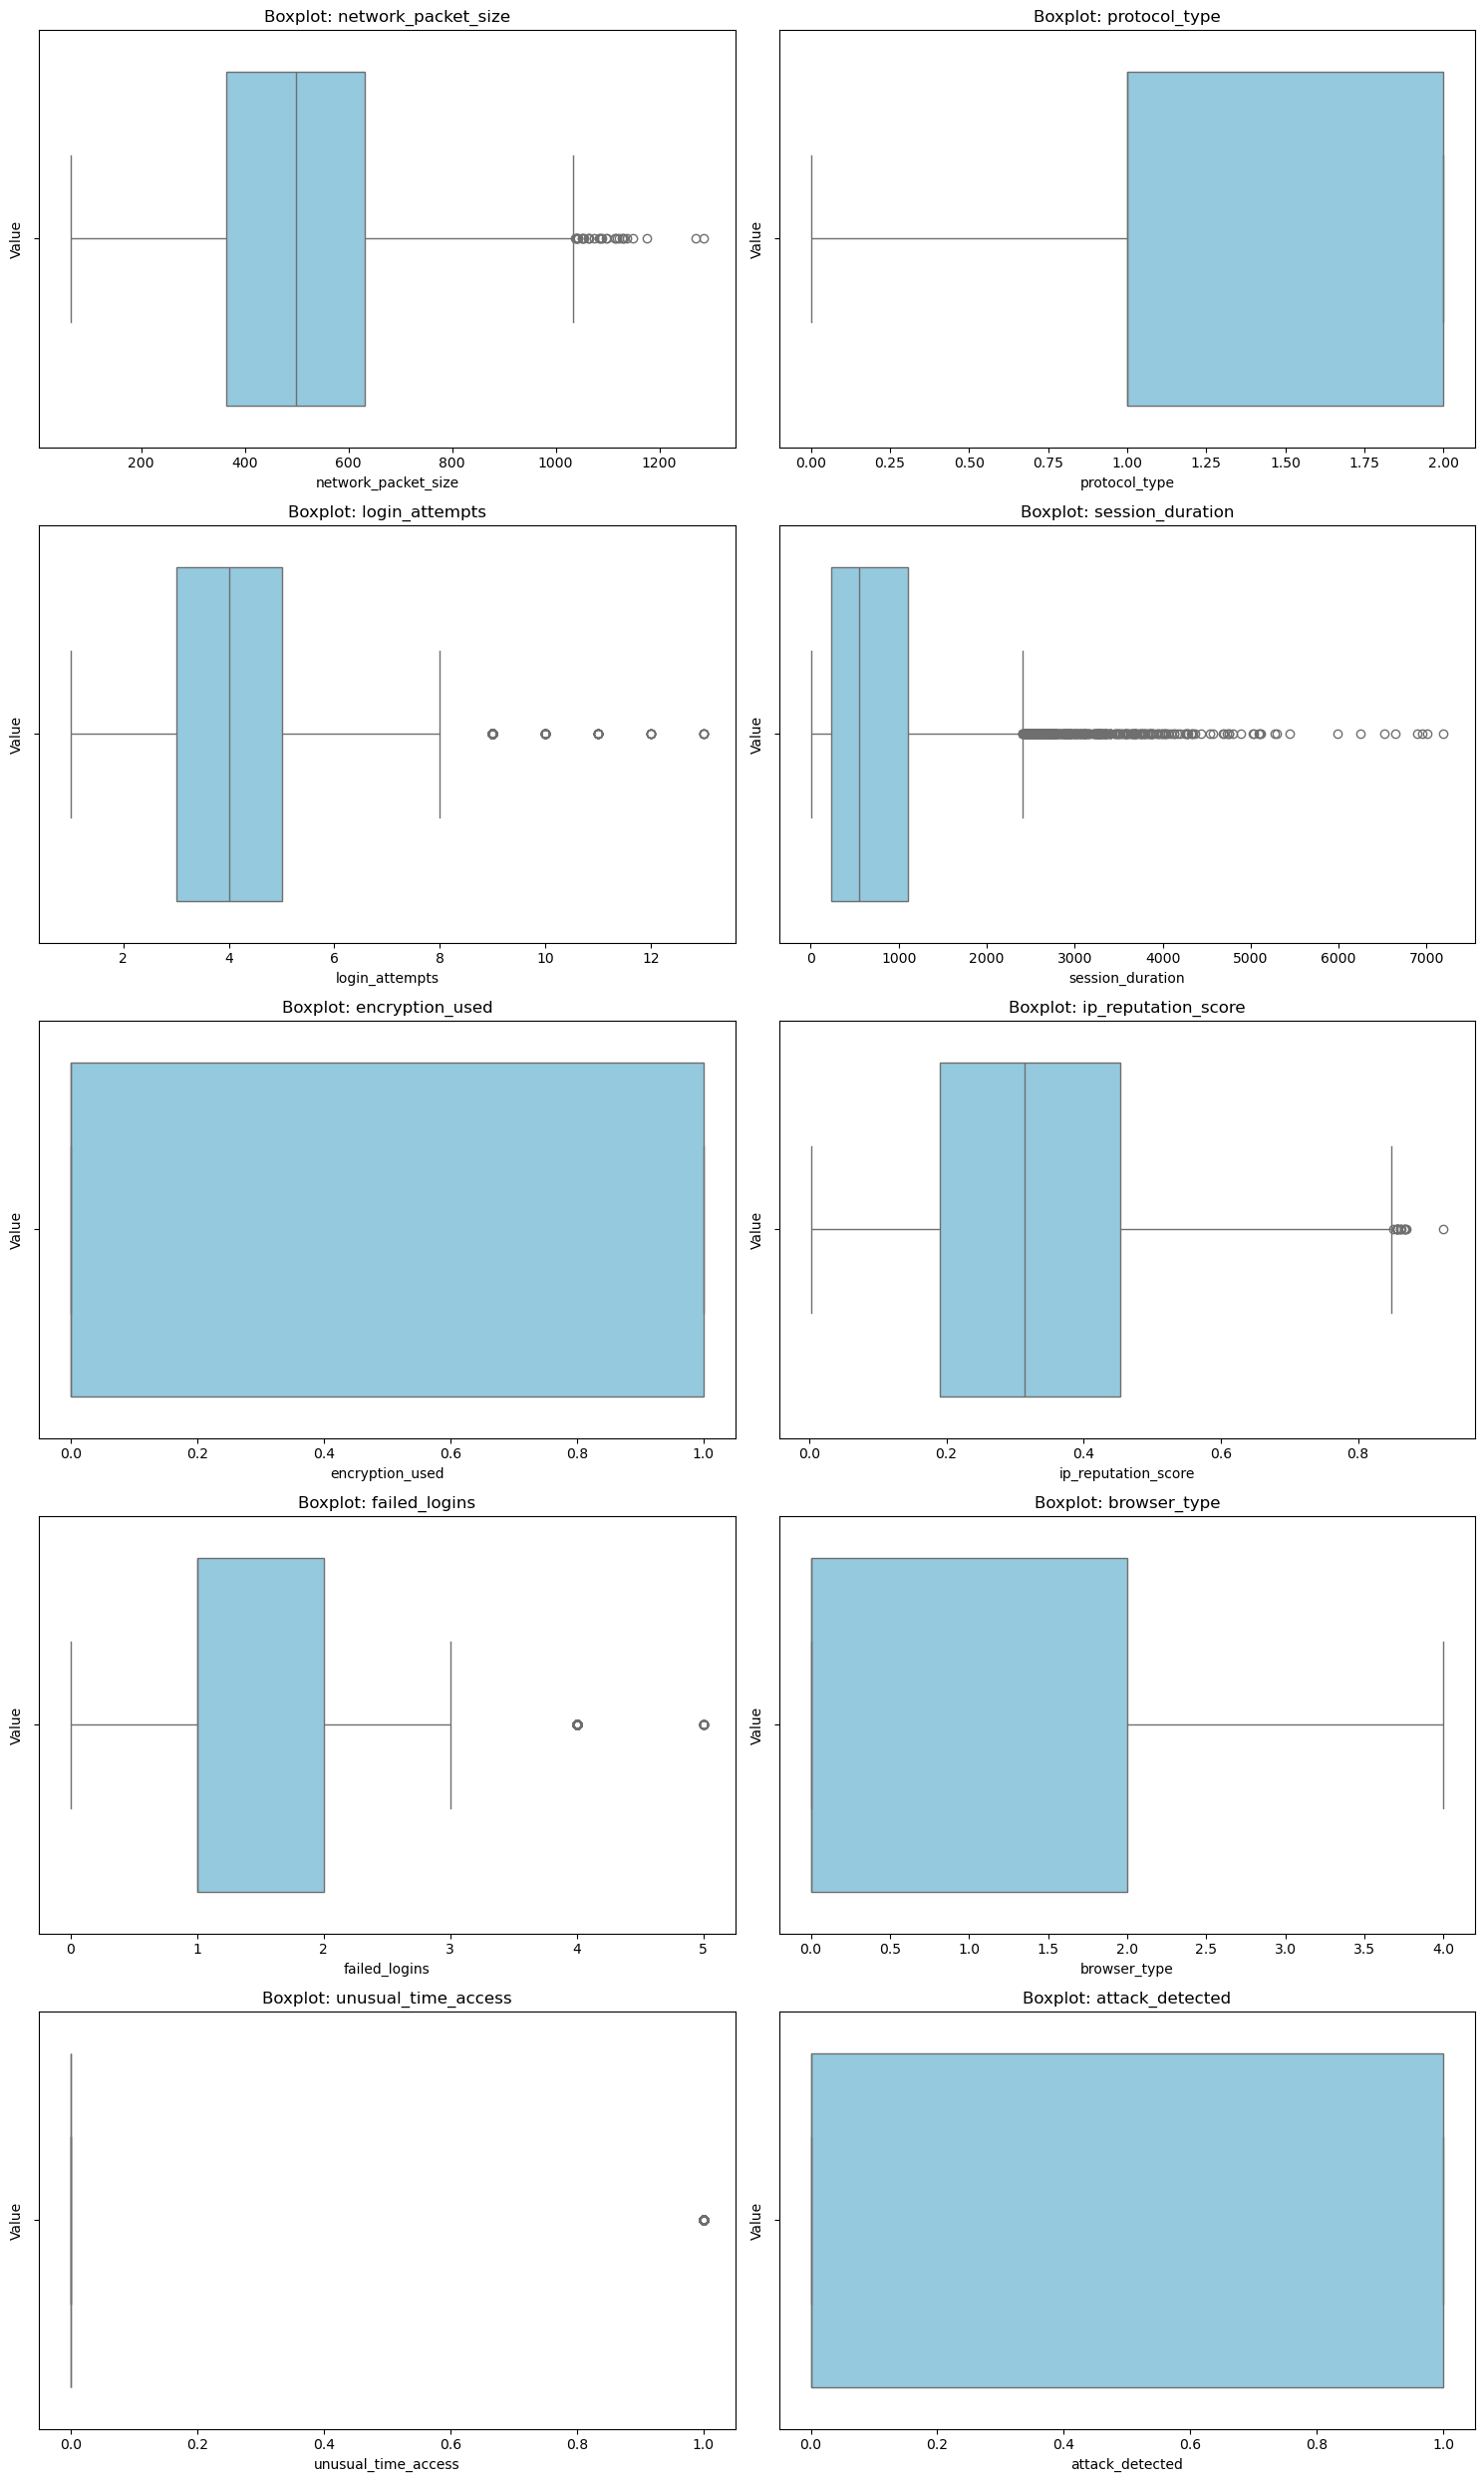

In [11]:
# ==========================
# Boxplots for numeric features
# ==========================

numeric_cols = df_intrusion_clean.select_dtypes(include=[np.number]).columns
num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df_intrusion_clean[column], color='skyblue')
    plt.title(f"Boxplot: {column}")
    plt.xlabel(column)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()


In [12]:
# =====================
# Data Modelling
# =====================

# Define models
models = {
    "Random Forest Classifier": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Decision Tree Classifier": DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "AdaBoost Classifier": AdaBoostClassifier(
        random_state=RANDOM_STATE
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    "Gradient Boosting Classifier": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    "Naive Bayes Classifier": GaussianNB()
}


In [13]:
# ===============================
# Split dataset into X (features) and y (target)
# ===============================

X = df_intrusion_clean.drop(["attack_detected"], axis=1)
y = df_intrusion_clean["attack_detected"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)


In [14]:
# =====================
# Standardise features
# =====================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
# ============================
# Model Evaluation Function
# ============================

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort models by F1 score (best metric for imbalanced data)
results_df = results_df.sort_values(by="F1", ascending=False)

print("=== Model Comparison Table ===")
display(results_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1": "{:.3f}"
}))


=== Model Comparison Table ===


,Model,Accuracy,Precision,Recall,F1
4,Gradient Boosting Classifier,0.895,0.921,0.881,0.890
0,Random Forest Classifier,0.894,0.920,0.881,0.889
2,AdaBoost Classifier,0.875,0.909,0.859,0.868
5,Naive Bayes Classifier,0.821,0.825,0.813,0.816
1,Decision Tree Classifier,0.811,0.808,0.809,0.809
3,Logistic Regression,0.733,0.730,0.725,0.726


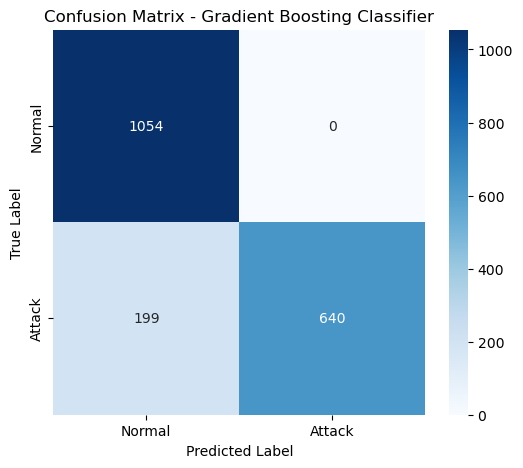

In [22]:
# ================================
# Confusion Matrix for Best Model (Gradient Boosting)
# ================================

best_model = models["Gradient Boosting Classifier"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<Figure size 1400x700 with 0 Axes>

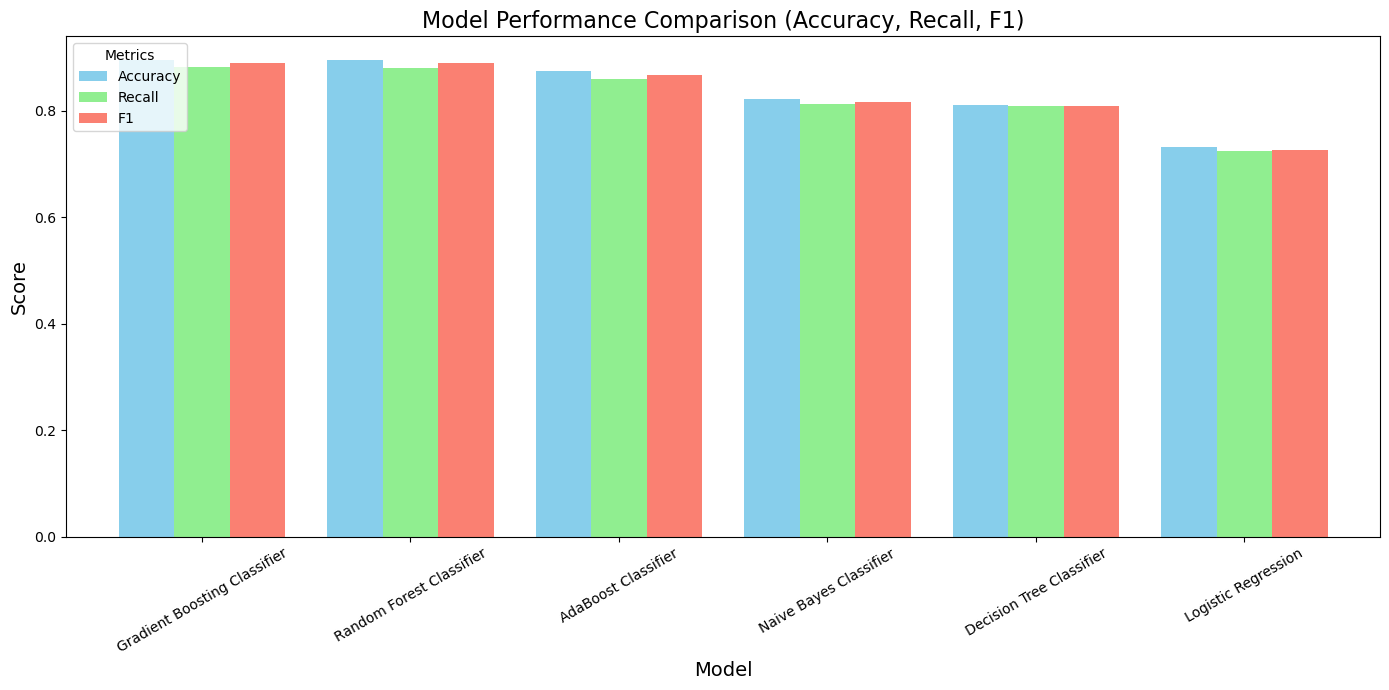

In [17]:
# =====================================
# Model Performance Comparison Chart
# =====================================

plt.figure(figsize=(14, 7))

plot_df = results_df.set_index("Model")[["Accuracy", "Recall", "F1"]]

plot_df.plot(
    kind='bar',
    width=0.8,
    figsize=(14, 7),
    color=['skyblue', 'lightgreen', 'salmon']
)

plt.title('Model Performance Comparison (Accuracy, Recall, F1)', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=30)
plt.legend(title='Metrics', loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
# ==========================================
# Best Model Selection (Random Forest)
# ==========================================

best_model = models["Random Forest Classifier"]

# Fit best model (ensures it's trained for scoring)
best_model.fit(X_train, y_train)

# Probability scores for positive class (1 = attack)
y_scores = best_model.predict_proba(X_test)[:, 1]


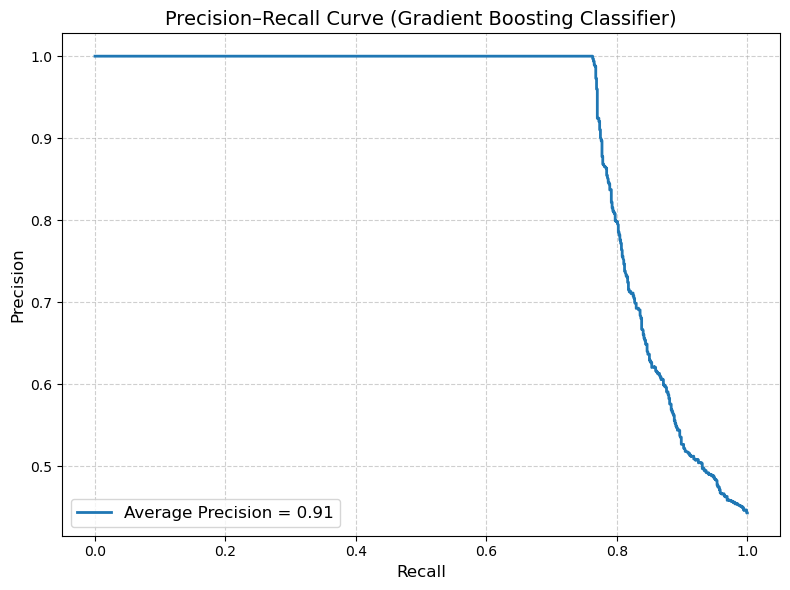

In [24]:
# ================================
# Precision–Recall Curve (Gradient Boosting)
# ================================
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use Gradient Boosting as best model
best_model = models["Gradient Boosting Classifier"]
best_model.fit(X_train, y_train)

# Get prediction scores (probability of class 1 = Attack)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Compute precision–recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2,
         label=f"Average Precision = {avg_precision:.2f}")

plt.title("Precision–Recall Curve (Gradient Boosting Classifier)", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


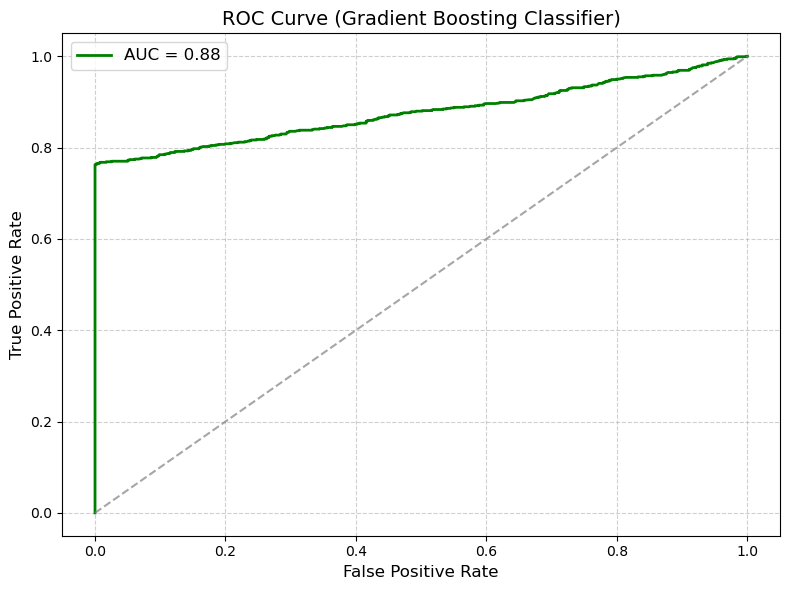

In [26]:
# ================================
# ROC Curve (Gradient Boosting)
# ================================
from sklearn.metrics import roc_curve, roc_auc_score

# Use Gradient Boosting as best-performing model
best_model = models["Gradient Boosting Classifier"]
best_model.fit(X_train, y_train)

# Get predicted probability scores for the positive class (Attack = 1)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', linewidth=2,
         label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', alpha=0.7)

plt.title("ROC Curve (Gradient Boosting Classifier)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
